In [4]:
import numba
import numpy as np
import matplotlib.pyplot as plt

def random_walk_returns_histogram(k, max_steps, trials, experiment):
    """
    Run 'trials' random walks in k dimensions, each of length 'max_steps'.
    Return a histogram (or count) of how many times the walk is at the origin
    for each step from 0..max_steps.

    Parameters:
    -----------
    k : int
        Dimension of the lattice.
    max_steps : int
        Maximum number of steps to simulate in each random walk.
    trials : int
        Number of random-walks.

    Returns:
    --------
    returns_count : numpy array of shape (max_steps+1,)
        returns_count[s] = number of walks at the origin after step s.
        Note that returns_count[0] = trials (since all start at origin).
    """

    @numba.njit
    def finite_brush(positions, returns_count, L):
        for step in range(1, max_steps + 1):
            for w in range(trials):
                # Randomly choose a dimension for each of the 'trials' walkers to move in
                if positions[w, 0] == 0:
                    dim_to_move = np.random.randint(low=0, high=k)
                    positions[w, dim_to_move] += np.random.choice(np.array([-1, 1]))
                else:
                    dim_to_move = 0
                    positions[w, 0] = abs(positions[w, 0])
                    if positions[w, 0] == L:
                        positions[w, dim_to_move] += -1
                    else:
                        positions[w, dim_to_move] += np.random.choice(np.array([-1, 1]))
                    
                   
                # Count how many are at the origin
                returns_count[step] += np.all(positions[w] == 0)

    @numba.njit
    def Zk(positions, returns_count):
        for step in range(1, max_steps + 1):
            for w in range(trials):
                # Randomly choose a dimension for each of the 'trials' walkers to move in
                dim_to_move = np.random.randint(low=0, high=k)
                positions[w, dim_to_move] += np.random.choice(np.array([-1, 1]))
                   
                # Count how many are at the origin
                returns_count[step] += np.all(positions[w] == 0)

    # This will track how many walks are at the origin at each step
    returns_count = np.zeros(max_steps + 1, dtype=int)

    # All walks start at origin => step 0 has 'trials' returns
    returns_count[0] = trials

    # For efficiency, keep track of positions in a single array
    # shape: (trials, k)
    if experiment == 'finite_brush':
        positions = np.zeros((trials, k+1), dtype=int)
        finite_brush(positions, returns_count, L=100)
    elif experiment == 'Zk':
        positions = np.zeros((trials, k), dtype=int)        
        Zk(positions, returns_count)
    else:
        assert False, experiment
        
    return returns_count


def local_linear_regression(X, Y, x_eval, bandwidth):
    """
    Perform local (kernel) linear regression at each point in x_eval.
    
    Parameters
    ----------
    X : array-like of shape (N,)
        The 'x' data points (independent variable).
    Y : array-like of shape (N,)
        The 'y' data points (dependent variable).
    x_eval : array-like of shape (M,)
        The points at which we want to estimate the local slope and intercept.
    bandwidth : float
        The kernel bandwidth sigma for the Gaussian weights.
    
    Returns
    -------
    slopes : array-like of shape (M,)
        The local slope at each x in x_eval.
    intercepts : array-like of shape (M,)
        The local intercept at each x in x_eval.
    """
    X = np.asarray(X)
    Y = np.asarray(Y)
    x_eval = np.asarray(x_eval)
    
    slopes = np.zeros_like(x_eval)
    intercepts = np.zeros_like(x_eval)
    
    for i, x0 in enumerate(x_eval):
        # Compute Gaussian weights w_i = exp( -((X_i - x0)^2)/(2 * bandwidth^2) )
        w = np.exp(-0.5 * ((X - x0) / bandwidth)**2)
        
        # Build design matrix A = [ [X_i, 1], ... ] for all i
        A = np.column_stack([X, np.ones_like(X)])
        
        # Weighted least squares solve: (A^T W A) alpha = A^T W Y
        # We'll build the "W^(1/2)" version to do it via an unweighted lstsq:
        W_sqrt = np.sqrt(w)
        A_w = A * W_sqrt[:, None]   # shape (N, 2)
        Y_w = Y * W_sqrt           # shape (N,)
        
        # Solve for alpha = [slope, intercept]
        alpha, residuals, rank, s = np.linalg.lstsq(A_w, Y_w, rcond=None)
        slope, intercept = alpha
        
        slopes[i] = slope
        intercepts[i] = intercept
    
    return slopes, intercepts

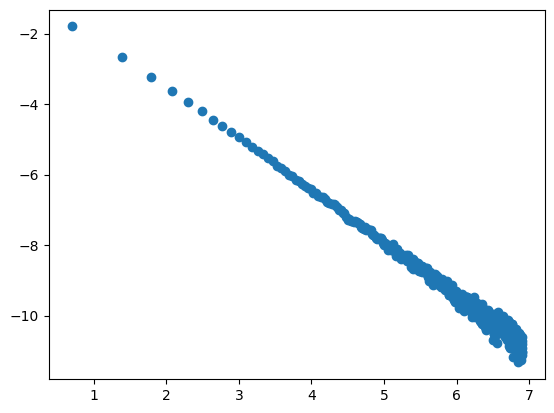

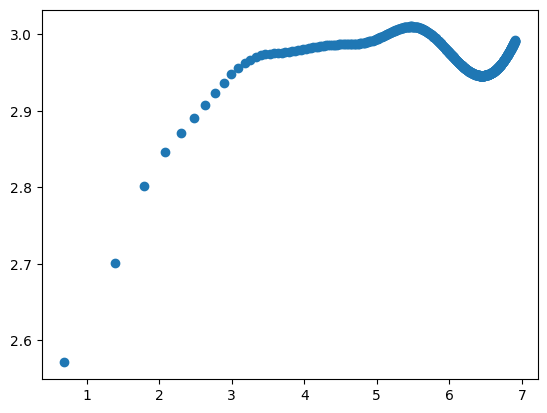


Log-Log Regression Results:
  slope (expected ~ -k/2 = -1.5): -1.4875
  intercept: -0.5025
  Estimated dimension: 2.9749


In [7]:


def experiment_Zk():
    k = 3  # dimension
    max_steps = 1000
    trials = int(1e6)

    # Get the histogram of how many walks return to origin at each step
    returns_count = random_walk_returns_histogram(k, max_steps, trials, experiment='Zk')


    empirical_probs = np.array(returns_count) / trials

    # --- Perform a log-log regression: log(emp_prob) ~ a * log(n) + b  ---

    # 1. Prepare the data for regression
    x = np.arange(len(empirical_probs))
    ix = np.where((empirical_probs > 0) & (x > 0))

    x = np.log(x[ix])
    y = np.log(empirical_probs[ix])

    f, ax = plt.subplots()
    ax.scatter(x, y)
    plt.show()
    
    bandwidth = 0.5  # you can experiment with this
    slopes, intercepts = local_linear_regression(x, y, x, bandwidth)

    f, ax = plt.subplots()
    ax.scatter(x, -2*slopes)
    plt.show()
    
    #import ipdb; ipdb.set_trace()
    # 2. Build the design matrix for linear regression in 2D: [log(n), 1]
    A = np.column_stack([x, np.ones_like(x)])

    # 3. Solve for [slope, intercept] = [a, b]
    #    log(emp_prob) = a * log(n) + b
    result = np.linalg.lstsq(A, y, rcond=None)
    (slope, intercept), residuals, rank, s = result

    # Print out the fit parameters
    print("\nLog-Log Regression Results:")
    print(f"  slope (expected ~ -k/2 = {-k/2}): {slope:.4f}")
    print(f"  intercept: {intercept:.4f}")
    print(f"  Estimated dimension: {-2*slope:.4f}")
    
experiment_Zk()

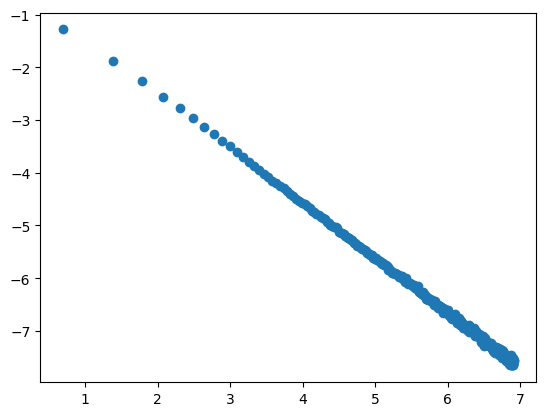

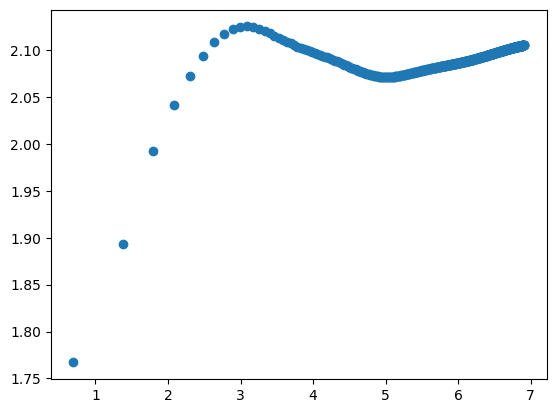


Log-Log Regression Results:
  slope (expected ~ -k/2 = -1.5): -1.0416
  intercept: -0.4107
  Estimated dimension: 2.0833


In [5]:


def experiment_finite_brush():
    k = 3  # dimension
    max_steps = 1000
    trials = int(1e6)

    # Get the histogram of how many walks return to origin at each step
    returns_count = random_walk_returns_histogram(k, max_steps, trials, experiment='finite_brush')


    empirical_probs = np.array(returns_count) / trials

    # --- Perform a log-log regression: log(emp_prob) ~ a * log(n) + b  ---

    # 1. Prepare the data for regression
    x = np.arange(len(empirical_probs))
    ix = np.where((empirical_probs > 0) & (x > 0))

    x = np.log(x[ix])
    y = np.log(empirical_probs[ix])

    f, ax = plt.subplots()
    ax.scatter(x, y)
    plt.show()
    
    bandwidth = 0.5  # you can experiment with this
    slopes, intercepts = local_linear_regression(x, y, x, bandwidth)

    f, ax = plt.subplots()
    ax.scatter(x, -2*slopes)
    plt.show()
    
    #import ipdb; ipdb.set_trace()
    # 2. Build the design matrix for linear regression in 2D: [log(n), 1]
    A = np.column_stack([x, np.ones_like(x)])

    # 3. Solve for [slope, intercept] = [a, b]
    #    log(emp_prob) = a * log(n) + b
    result = np.linalg.lstsq(A, y, rcond=None)
    (slope, intercept), residuals, rank, s = result

    # Print out the fit parameters
    print("\nLog-Log Regression Results:")
    print(f"  slope (expected ~ -k/2 = {-k/2}): {slope:.4f}")
    print(f"  intercept: {intercept:.4f}")
    print(f"  Estimated dimension: {-2*slope:.4f}")
    
experiment_finite_brush()

In [7]:
np.exp(5)

148.4131591025766